In [1]:
# Ignore warnings
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller

In [2]:
def download_data(ticker, start_date="2019-01-01"):
    # download ticker data from yfinance library
    df = yf.download(ticker, start=start_date, end="2024-08-17")  # end date set so numbers stop fluctuating
    df.dropna(inplace=True)
    return df

# download data
ticker1 = "KO"
ticker2 = "PEP"
index_ticker = "SPY"
start_date = "2020-01-01"
df_ko = download_data(ticker1, start_date)
df_pep = download_data(ticker2, start_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
df_ko.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,55.320000,55.430000,54.759998,54.990002,47.777241,11867700
2020-01-03,54.320000,54.990002,54.090000,54.689999,47.516590,11354500
2020-01-06,54.650002,54.910000,54.520000,54.669998,47.499210,14698300
2020-01-07,54.450001,54.599998,54.150002,54.250000,47.134304,9973900
2020-01-08,54.270000,54.639999,54.150002,54.349998,47.221191,10676000


In [4]:
df_pep.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-08-12,172.240005,172.869995,170.710007,171.419998,171.419998,3802300
2024-08-13,171.619995,172.419998,170.220001,172.369995,172.369995,3894700
2024-08-14,172.229996,174.339996,171.929993,173.710007,173.710007,3555800
2024-08-15,173.710007,174.300003,171.830002,172.520004,172.520004,4472100
2024-08-16,172.520004,172.779999,171.110001,172.619995,172.619995,4614600


In [5]:
def prepare_time_series(data1, data2, ticker1, ticker2, index_ticker="SPY"):
    # download index data
    index_data = download_data(index_ticker)

    # among the 3 dataframes: determine latest start date and trim all dataframes to start there
    latest_start_date = max(data1.index.min(), data2.index.min(), index_data.index.min())
    data1 = data1[data1.index >= latest_start_date]
    data2 = data2[data2.index >= latest_start_date]
    index_data = index_data[index_data.index >= latest_start_date]

    # combine the 3 trimmed dataframes into 1
    data = pd.concat([data1['Close'], data2['Close'], index_data['Close']], axis=1).dropna()

    data.columns = [ticker1, ticker2, index_ticker]
    return data

data = prepare_time_series(df_ko, df_pep, ticker1, ticker2)
data.head()

[*********************100%%**********************]  1 of 1 completed


,KO,PEP,SPY
Date,,,
2020-01-02,54.990002,135.820007,324.869995
2020-01-03,54.689999,135.630005,322.410004
2020-01-06,54.669998,136.149994,323.640015
2020-01-07,54.250000,134.009995,322.730011
2020-01-08,54.349998,134.699997,324.450012


Inspired from Machine Learning inspired backtesting, we will now split the data into training data and testing data. We will use a chronological split of 70% training data and 30% test data. The entire cointegration analysis will be based entirely off of training. The approach implemented ensures that the training data *precedes* the test data, simulating a real-world scenario where an investor would only have access to past data when making trading decisions.

In [6]:
def split_data(data, split_ratio=0.8):
    """Splits the input data into training and testing subsets based on the provided split ratio."""
    split_index = int(len(data) * split_ratio)
    train_data = data.iloc[:split_index]
    test_data = data.iloc[split_index:]
    return train_data, test_data

train_data, test_data = split_data(data, split_ratio=0.7)

In [7]:
data

,KO,PEP,SPY
Date,,,
2020-01-02,54.990002,135.820007,324.869995
2020-01-03,54.689999,135.630005,322.410004
2020-01-06,54.669998,136.149994,323.640015
2020-01-07,54.250000,134.009995,322.730011
2020-01-08,54.349998,134.699997,324.450012
...,...,...,...
2024-08-12,68.169998,171.419998,533.270020
2024-08-13,68.459999,172.369995,542.039978
2024-08-14,68.580002,173.710007,543.750000


In [8]:
train_data.head()

,KO,PEP,SPY
Date,,,
2020-01-02,54.990002,135.820007,324.869995
2020-01-03,54.689999,135.630005,322.410004
2020-01-06,54.669998,136.149994,323.640015
2020-01-07,54.250000,134.009995,322.730011
2020-01-08,54.349998,134.699997,324.450012


In [9]:
test_data.head()

,KO,PEP,SPY
Date,,,
2023-03-28,61.419998,179.429993,395.600006
2023-03-29,61.860001,180.669998,401.350006
2023-03-30,61.849998,180.830002,403.700012
2023-03-31,62.029999,182.300003,409.390015
2023-04-03,62.400002,182.500000,410.950012


# Engle-Granger method: Cointegration analysis between time series

## Step 1: Residual anaylsis between price time series $X_t, Y_t$


1. **Linear regression of $X_t$ onto $Y_t$ to describe long-term equilibrium relationship**:

The regression equation is: $$Y_t = \beta_0 + \beta_1 X_t + e_t$$ where $e_t$ is the residual.


2. **ADF Test on Residuals:**

It follows from the regression equation that $$e_t = Y_t - \beta_0 - \beta_1 X_t.$$ If $X_t$ and $Y_t$ are cointegrated, then the residuals $e_t$ must be stationary. To find out whether a time series is stationary, we conduct the *Augmented Dickey-Fuller (ADF) test* to check for stationarity of $e_t$.

The *ADF test* checks for unit roots in time series. The null hypothesis is that the tested time series $e_t$ has a unit root and is therefore non-stationary. If the p-value is below a certain significant value (e.g. 5% or 1%), we reject the null hypothesis, indicating that the series is stationary.

In [10]:
def least_squares_regression(y, X):
    """Perform least squares regression to obtain beta coefficients and residuals."""
    X = np.hstack([np.ones((X.shape[0], 1)), X])  # add y-intercept to X
    beta = np.linalg.inv(X.T @ X) @ (X.T @ y)  # least squares regression for beta
    residuals = y - X @ beta
    return beta, residuals


# Perform ordinary least square (OLS) regression
y = train_data[ticker1].values
X = train_data[ticker2].values.reshape(-1, 1)
beta, residuals = least_squares_regression(y, X)
train_data['residuals'] = residuals
train_data.head()

,KO,PEP,SPY,residuals
Date,,,,
2020-01-02,54.990002,135.820007,324.869995,5.061209
2020-01-03,54.689999,135.630005,322.410004,4.819388
2020-01-06,54.669998,136.149994,323.640015,4.640158
2020-01-07,54.250000,134.009995,322.730011,4.875466
2020-01-08,54.349998,134.699997,324.450012,4.764173


In [11]:
beta  # i.e. KO_t = beta[0] + beta[1] * PEP_t + e_t

array([8.33829699, 0.30621774])

In our case, writing $\beta = \left(\beta_0, \beta_1\right) \approx \left(8.34, 0.31\right)$, the linear regression yields the following relationship between the time series of KO and PEP: $$\text{KO}_t = \beta_0 + \beta_1 \text{PEP}_t + e_t,$$ where $e_t$ denotes the time series of residuals in the dataframe, also shown here:

In [12]:
train_data['residuals']

Date
2020-01-02    5.061209
2020-01-03    4.819388
2020-01-06    4.640158
2020-01-07    4.875466
2020-01-08    4.764173
                ...   
2023-03-21   -2.528115
2023-03-22   -2.338789
2023-03-23   -2.205443
2023-03-24   -2.278829
2023-03-27   -1.951322
Name: residuals, Length: 814, dtype: float64

We need to also add the `'residuals'` column to the `test_data` for all further implementations to work. We wil re-use the $\beta_0, \beta_1$ from the OLS on the `train_data`.

In [13]:
def calculate_test_residuals(data, beta, ticker1, ticker2):
    """Calculate the residuals for a given dataset using the provided beta vector."""
    y = data[ticker1].values
    X = data[ticker2].values
    X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X.reshape(-1, 1)])
    residuals = y - X_with_intercept @ beta
    return pd.Series(residuals, index=data.index)

test_data['residuals'] = calculate_test_residuals(test_data, beta, ticker1, ticker2)

In [14]:
test_data

,KO,PEP,SPY,residuals
Date,,,,
2023-03-28,61.419998,179.429993,395.600006,-1.862945
2023-03-29,61.860001,180.669998,401.350006,-1.802655
2023-03-30,61.849998,180.830002,403.700012,-1.861653
2023-03-31,62.029999,182.300003,409.390015,-2.131793
2023-04-03,62.400002,182.500000,410.950012,-1.823033
...,...,...,...,...
2024-08-12,68.169998,171.419998,533.270020,7.339857
2024-08-13,68.459999,172.369995,542.039978,7.338952
2024-08-14,68.580002,173.710007,543.750000,7.048619


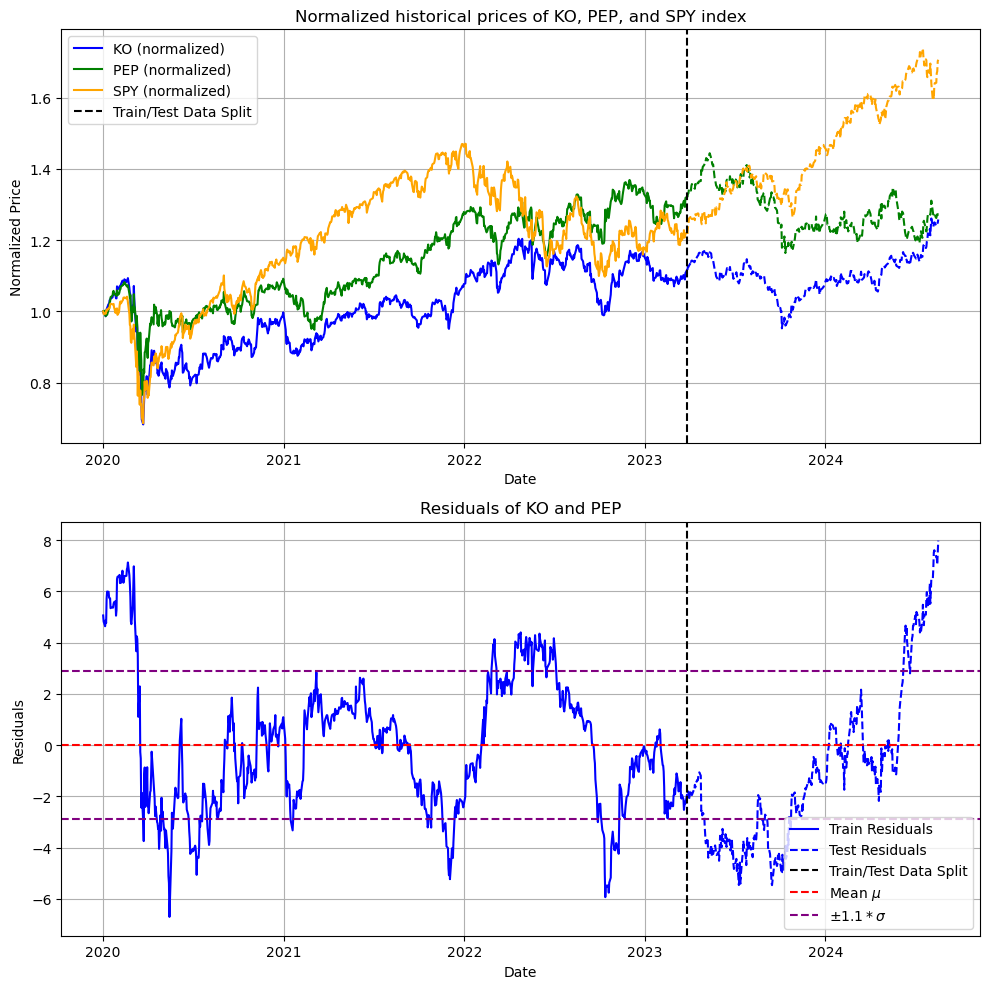

In [15]:
def plot_assets_and_residuals(train_data, test_data, ticker1, ticker2, index_ticker="SPY", split_ratio=0.7):
    plt.figure(figsize=(10, 10))

    # normalize historical prices for train data
    normalized_train_ticker1 = train_data[ticker1] / train_data[ticker1].iloc[0]
    normalized_train_ticker2 = train_data[ticker2] / train_data[ticker2].iloc[0]
    normalized_train_index = train_data[index_ticker] / train_data[index_ticker].iloc[0]

    # normalize historical prices for test data
    normalized_test_ticker1 = test_data[ticker1] / train_data[ticker1].iloc[0]
    normalized_test_ticker2 = test_data[ticker2] / train_data[ticker2].iloc[0]
    normalized_test_index = test_data[index_ticker] / train_data[index_ticker].iloc[0]

    # determine the split date
    split_date = train_data.index[-1]

    # plot normalized prices
    plt.subplot(2, 1, 1)
    plt.plot(train_data.index, normalized_train_ticker1, label=f"{ticker1} (normalized)", color="blue")
    plt.plot(train_data.index, normalized_train_ticker2, label=f"{ticker2} (normalized)", color="green")
    plt.plot(train_data.index, normalized_train_index, label=f"{index_ticker} (normalized)", color="orange")
    
    plt.plot(test_data.index, normalized_test_ticker1, color="blue", linestyle="--")
    plt.plot(test_data.index, normalized_test_ticker2, color="green", linestyle="--")
    plt.plot(test_data.index, normalized_test_index, color="orange", linestyle="--")
    
    plt.axvline(split_date, color="black", linestyle="--", label="Train/Test Data Split")
    plt.title(f"Normalized historical prices of {ticker1}, {ticker2}, and {index_ticker} index")
    plt.xlabel("Date")
    plt.ylabel("Normalized Price")
    plt.legend()
    plt.grid(True)

    # plot residuals for train and test data
    plt.subplot(2, 1, 2)
    plt.plot(train_data.index, train_data['residuals'], label="Train Residuals", color="blue")
    plt.plot(test_data.index, test_data['residuals'], label="Test Residuals", color="blue", linestyle="--")
    
    plt.axvline(split_date, color="black", linestyle="--", label="Train/Test Data Split")
    mean = train_data['residuals'].mean()
    stdev = train_data['residuals'].std()
    plt.axhline(mean, color="r", linestyle='--', label=f"Mean $\mu$")
    plt.axhline(mean + 1.1 * stdev, color="purple", linestyle="--", label="$\pm1.1*\sigma$")
    plt.axhline(mean - 1.1 * stdev, color="purple", linestyle="--")
    
    plt.title(f"Residuals of {ticker1} and {ticker2}")
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_assets_and_residuals(train_data, test_data, ticker1, ticker2)

In [16]:
def perform_adf_test(residuals, significance_level, maxlag=None):
    """Perform the Augmented Dickey-Fuller (ADF) test to check for the presence of unit root in a time series.
    H0: time series has a unit root (i.e. non-stationary)"""
    adf_test = adfuller(residuals, maxlag=maxlag, autolag=None)
    # autolag=None will set lag nbr to maxlag (no lag optimization) if maxlag is not None
    # if maxlag and autolag are both None, then lag nbr will be optimized using AIC
    adf_statistic, p_value, lags = adf_test[0], adf_test[1], adf_test[2]

    print(f"ADF Statistic: {adf_statistic:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Number of lags: {lags}")

    if p_value < significance_level:
        print(f"The residuals are stationary (reject null hypothesis) "
              f"at the {significance_level * 100}% significance level.")
    else:
        print(f"The residuals are not stationary (fail to reject null hypothesis) "
              f"at the {significance_level * 100}% significance level.")
    return adf_test


adf_test_result = perform_adf_test(train_data['residuals'], significance_level=0.05, maxlag=1)

ADF Statistic: -2.9216
p-value: 0.0429
Number of lags: 1
The residuals are stationary (reject null hypothesis) at the 5.0% significance level.


In [17]:
adf_test_result  # performed with maxlag set to 1

(-2.9216213196257614,
 0.04289088508281764,
 1,
 812,
 {'1%': -3.4384289321263126,
  '5%': -2.865105979079729,
  '10%': -2.568668841575869})

In [18]:
perform_adf_test(train_data['residuals'], significance_level=0.05,)
# including lag optimization using AIC

ADF Statistic: -3.4231
p-value: 0.0102
Number of lags: 21
The residuals are stationary (reject null hypothesis) at the 5.0% significance level.


(-3.4231220119229504,
 0.01019544920805371,
 21,
 792,
 {'1%': -3.438633612472885,
  '5%': -2.865196199232788,
  '10%': -2.5687169024206713})

#### Conclusion of Engle-Granger Step 1 for the example of KO and PEP

The regression model following $$Y_t = \beta_0 + \beta_1 X_t + e_t$$ yields $$\text{KO}_t = \beta_0 + \beta_1 \text{PEP}_t + e_t$$ with $\beta = \left(\beta_0, \beta_1\right) \approx \left(8.34, 0.31\right)$ for our case.

The Augmented Dickey-Fuller test displayed a very low p-value. We therefore strongly reject the null hypothesis of a unit root at both 5% and 1% significance level, implying that the time series of KO and PEP are cointegrated.

#### Coefficients analysis

$\beta_0$ as the intercept describes the part of KO's price that is independent of PEP.

$\beta_1$ models the linear dependency between KO and PEP in the long-term equilibrium. In practice, this can be used as a hedge ratio, because for every unit change in PEP's price, KO prices will increase by $\beta_1\approx 0.31$ on average.

## Step 2 of Engle-Granger: ECM

The ECM now considers the absolute returns (differences) $\Delta X_t = X_t - X_{t-1}$ (e.g., PEP) and $\Delta Y_t = Y_t - Y_{t-1}$ (e.g., KO). Considering such differences removes long-term continuous effects and is more suitable to analyze short-term dynamics.

The Equilibrium Correction Model (ECM) classically follows the equation
$$\Delta Y_t =\alpha_0+\alpha_1 \cdot \Delta X_t + \alpha_2\cdot e_{t-1}+\varepsilon_t,$$
where
* $e_{t-1}$ denotes the lagged residuals from the previous cointegration regression.
* $\alpha=\left(\alpha_0, \alpha_1, \alpha_2\right)$ is the coefficient of the ECM regression. In particular, $\alpha_2$ is the error correction term coefficient of the residual term $e_{t-1}$, representing the speed of adjustment towards the long-term equilibrium.
* $\varepsilon_t$ denotes the "new" residual terms, inferred from regressing the ECM.

In [19]:
def get_differences(data, columns):
    """Calculate the returns (differences) Delta y_t = y_t-y_{t-1} for the specified columns in the dataframe."""
    return data[columns].diff().dropna()


def fit_ecm(data, target_column, independent_column, lag_size=1):
    """Step2 of the Engle-Granger procedure: fit the Equilibrium Correction Model (ECM)."""
    data_delta = get_differences(data, [target_column, independent_column])
    data_delta['lagged_residuals'] = data['residuals'].shift(lag_size)  # lag the residuals
    data_delta = data_delta.dropna()

    # OLS to obtain ECM coefficients & residuals
    y = data_delta[target_column].values
    X = data_delta[[independent_column, "lagged_residuals"]].values
    ecm_coefficients, ecm_residuals = least_squares_regression(y, X)

    ecm_residuals = pd.DataFrame(ecm_residuals, index=data_delta.index, columns=["ECM_residuals"])  # convert to pd.df
    return {'coefficients': ecm_coefficients, 'residuals': ecm_residuals}


# Fit the ECM for KO and PEP
lag_size = adf_test_result[2]
ecm_results = fit_ecm(train_data, ticker1, ticker2, lag_size)
print("ECM Coefficients:", ecm_results['coefficients'])
print("ECM Residuals:", ecm_results['residuals'])

ECM Coefficients: [-0.007458    0.28539525 -0.02042664]
ECM Residuals:             ECM_residuals
Date                     
2020-01-03      -0.134936
2020-01-06      -0.062501
2020-01-07       0.292988
2020-01-08       0.010122
2020-01-09       1.069091
...                   ...
2023-03-21      -0.435701
2023-03-22       0.113910
2023-03-23       0.075123
2023-03-24      -0.039349
2023-03-27       0.296745

[813 rows x 1 columns]


### Conclusion of Engle-Granger Step 2 for the example of KO and PEP

The ECM regression for the considered example can be formulated as
$$\Delta\text{KO}_t = \alpha_0 + \alpha_1 \Delta\text{PEP}_t + \alpha_2 e_{t-1} + \varepsilon_t$$
with $\alpha = \left(\alpha_0, \alpha_1, \alpha_2\right) \approx \left(-0.01, 0.29, -0.02\right)$.

#### Coefficients analysis

$\alpha_1$ is the coefficient that best describes the linear relationship between KO and PEP for shorter-term periods. It signifies that a unit change in $\Delta X_t = \Delta\text{PEP}_t$ results in a $\alpha_1\approx 0.29$ change in $\Delta Y_t = \Delta\text{KO}_t$.

The negative sign of $\alpha_2\approx -0.02$ indicates a mean-reversion towards the long-term mean since it suggests a tendency to correct deviations from the equilibrium.

#### Residuals comparison

While the previously calculated residuals $e_t$ represent deviations from the long-term equilibrium between KO and PEP, the ECM residual time series $\varepsilon_t$ represent deviations in the changes in KO prices after accounting for changes in PEP prices, with short-term dynamics and mean-reverting behavior removed from the model.

Therefore, $\varepsilon_t$ should expectedly be lower in magnitude than the long-term equilibrium residuals $e_t$ and hover closely around $0$ with no obvious patterns - similar to white noise residuals, reflecting that most of the short-term dynamics and mean-reverting corrections to the long-term mean have already been accounted for.

Indeed a plot shows the described behaviour:

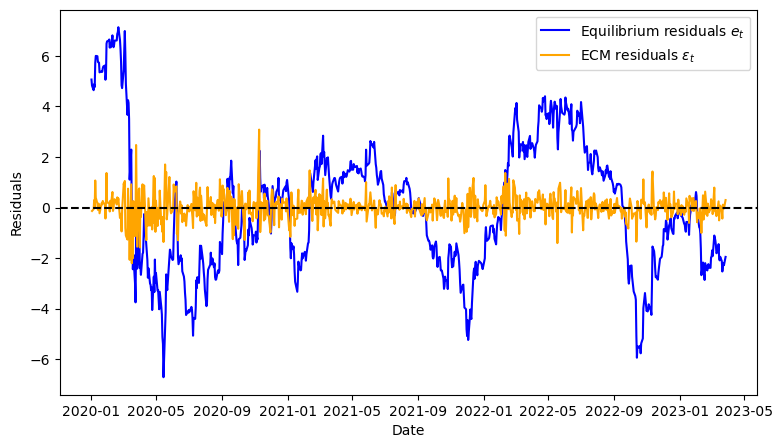

In [20]:
plt.figure(figsize=(9, 5))
plt.plot(train_data.index, train_data['residuals'], label="Equilibrium residuals $e_t$", color="blue")
# Align indices for lagged epsilon residuals
plt.plot(train_data.index[1:], ecm_results['residuals'], label="ECM residuals $\epsilon_t$", color="orange")
plt.axhline(0, color='black', linestyle='--')
#plt.title("Comparison of Residuals from Engle-Granger Method")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.legend()
plt.show()

## Step 3 (inofficial): Ornstein-Uhlenbeck process for mean-reverting residuals

$$d e_t = -\theta (e_t - \mu_e) dt + \sigma_{OU} dW_t,$$ where $\theta$ is the speed of mean-reversion to long-term equilibrium mean $\mu_e$ and $\sigma_{OU}$ is the standard deviation (volatility) of the process.


In [21]:
def ou_likelihood(params, residuals, dt):
    """Calculates the negative log-likelihood of an Ornstein-Uhlenbeck process"""
    theta, mu_e, sigma_ou = params
    likelihood = 0
    for t in range(1, len(residuals)):
        mean = residuals[t-1] + theta * (mu_e - residuals[t-1]) * dt
        variance = sigma_ou**2 * dt
        # increment the log-likelihood by normal log-pdf of the next residual using mean and variance
        likelihood += norm.logpdf(residuals[t], loc=mean, scale=np.sqrt(variance))
    return -likelihood


def estimate_ou_params(residuals, dt=1):  # dt = 1: daily prices, so usually time increment dt = 1
    """Estimate Ornstein-Uhlenbeck process parameters using maximum likelihood estimation.
    The OU process is given as: d(residuals)_t = -theta (residuals_t-mu_e) dt + sigma_ou dW_t"""
    residuals = np.array(residuals)
    initial_params = [0.1, np.mean(residuals), np.std(residuals)]  # [theta0, mu_ou0, sigma_ou0]
    # we minimize negative log-likelihood, which is equivalent to using maximum likelihood estimator (MLE)
    result = minimize(ou_likelihood, initial_params, args=(residuals, dt), method="L-BFGS-B")
    theta, mu_e, sigma_ou = result.x
    return theta, mu_e, sigma_ou


theta, mu_e, sigma_ou = estimate_ou_params(train_data['residuals'])
print(f"Estimated OU parameters: theta={theta:.4f}, mu_e={mu_e:.4f}, sigma_ou={sigma_ou:.4f}")

Estimated OU parameters: theta=0.0197, mu_e=-0.4343, sigma_ou=0.4925


In [22]:
ou_params = {'theta': theta, 'mu_e': mu_e, 'sigma_ou': sigma_ou}

### Visualizing the simulated OU process against the actual residuals $e_t$:

Simulation of Ornstein-Uhlenbeck process with the estimated parameters $(\theta, \mu_e, \sigma_{ou})\approx \left(0.0197, -0.4343, 0.4925\right)$ should display similar dynamics as the actual residuals time series $e_t$. However, some deviations from the original residual time series $e_t$ are still expected, since the OU process is a continuous-time stochastic process simulated from an SDE including Brownian increments (randomness).

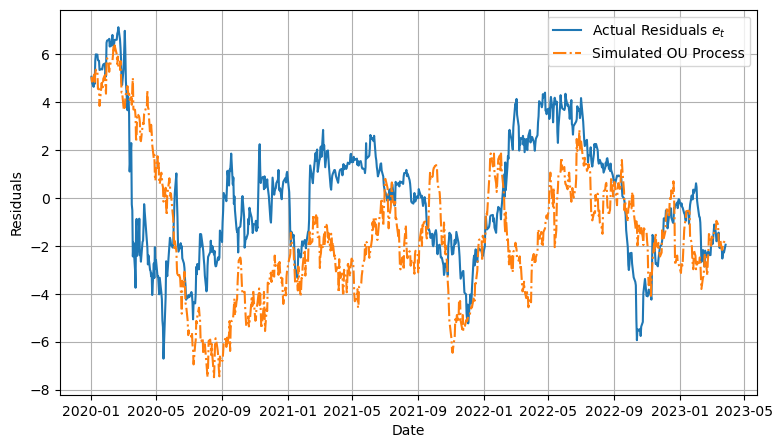

In [23]:
def simulate_ou_process(theta, mu_e, sigma_ou, initial_value, num_steps, dt=1):
    """Simulate an Ornstein-Uhlenbeck process."""
    ou_process = np.zeros(num_steps)
    ou_process[0] = initial_value
    for t in range(1, num_steps):
        ou_process[t] = ou_process[t-1] + theta * (mu_e - ou_process[t-1]) * dt + sigma_ou * np.sqrt(dt) * np.random.normal()
    return ou_process

# Simulate an OU process with the estimated parameters
num_steps = len(train_data['residuals'])
initial_value = train_data['residuals'].iloc[0]
simulated_residuals = simulate_ou_process(theta, mu_e, sigma_ou, initial_value, num_steps)

# Plot the actual residuals and the simulated OU process
plt.figure(figsize=(9, 5))
plt.plot(train_data.index, train_data['residuals'], label="Actual Residuals $e_t$")
plt.plot(train_data.index, simulated_residuals, label="Simulated OU Process", linestyle="-.")
plt.xlabel("Date")
plt.ylabel("Residuals")
#plt.title("Actual Residuals vs. Simulated Ornstein-Uhlenbeck Process")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
print(f"Half-life of OU process: {np.log(2)/theta:.2f} trading days") 

Half-life of OU process: 35.10 trading days


# Trading strategy based on mean-reversion analysis

Using $\beta_1$ as hedge ratio as previously discussed...

In [25]:
hedge_ratio = beta[1]

In [26]:
class Portfolio:
    def __init__(self, data, ticker1, ticker2, ou_params, hedge_ratio, z):
        self.data = data
        self.ticker1 = ticker1
        self.ticker2 = ticker2
        self.theta = ou_params['theta']
        self.sigma_ou = ou_params['sigma_ou']
        self.mu_e = ou_params['mu_e']
        self.hedge_ratio = hedge_ratio
        self.z = z
        self.realized_daily_pnl = pd.Series(index=data.index, dtype=float).fillna(0)
        self.unrealized_daily_pnl = pd.Series(index=data.index, dtype=float).fillna(0)
        self.positions = pd.DataFrame(index=data.index, columns=[ticker1, ticker2]).fillna(0)
        self.returns = []
        self.manage_positions()

    def calculate_optimal_bounds(self):
        """Calculate the upper and lower bounds for trading, CQF FP Workshop 2, sl. 15."""
        sigma_eq = self.sigma_ou / np.sqrt(2 * self.theta)
        bound1 = self.mu_e + self.z * sigma_eq
        bound2 = self.mu_e - self.z * sigma_eq
        return tuple(sorted([bound1, bound2], reverse=True))  # return upper bound first, then lower bound

    def enter_position(self, row, position_ticker1, position_ticker2):
        """Enter a position based on the current market conditions."""
        entry_price_ticker1 = row[self.ticker1]
        entry_price_ticker2 = row[self.ticker2]
        return position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2

    def calculate_trade_pnl(self, row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2):
        """Calculate the PnL of the trade."""
        if position_ticker1 == 1 and position_ticker2 == -self.hedge_ratio:
            trade_pnl = (row[self.ticker1] - entry_price_ticker1) + (entry_price_ticker2 - row[self.ticker2]) * self.hedge_ratio
        elif position_ticker1 == -1 and position_ticker2 == self.hedge_ratio:
            trade_pnl = (entry_price_ticker1 - row[self.ticker1]) + (row[self.ticker2] - entry_price_ticker2) * self.hedge_ratio
        else:
            trade_pnl = 0
        return trade_pnl

    def calculate_unrealized_pnl(self, row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2):
        """Calculate the unrealized PnL for the day based on the movement of ticker1 and ticker2."""
        if position_ticker1 != 0 and position_ticker2 != 0:  # If a position is open
            unrealized_pnl = self.calculate_trade_pnl(row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2)
        else:
            unrealized_pnl = 0  # No unrealized PnL if no position is open
        return unrealized_pnl

    def append_return(self, trade_pnl, entry_price_ticker1, entry_price_ticker2):
        """Append the return (either simple or log) to the self.returns list."""
        simple_return = trade_pnl / (entry_price_ticker1 + self.hedge_ratio * entry_price_ticker2)
        self.returns.append(simple_return)

    def close_position(self, row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2):
        """Close the position and calculate realized PnL."""
        trade_pnl = self.calculate_trade_pnl(row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2)
        if trade_pnl != 0:
            self.append_return(trade_pnl, entry_price_ticker1, entry_price_ticker2)
            self.realized_daily_pnl.at[row.name] += trade_pnl  # add realized PnL
        return 0, 0, 0, 0  # reset positions and entry prices

    def manage_positions(self):
        """Manage positions for the trading strategy exploiting mean-reversion of 2 cointegrated assets using
        hedge ratio (beta1) previously obtained in Engle-Granger step 1 and track daily PnL."""
        position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2 = 0, 0, 0, 0
        upper_bound, lower_bound = self.calculate_optimal_bounds()

        # initialize the first value of both daily PnLs to 0
        previous_realized_pnl = 0

        for index, row in self.data.iterrows():
            residual = row['residuals']

            # entry conditions
            if position_ticker1 == 0 and position_ticker2 == 0:
                if residual > upper_bound:  # very positive spread
                    # short ticker1 (over-valued from equilibrium), long ticker2
                    position_ticker1, position_ticker2 = -1, self.hedge_ratio
                elif residual < lower_bound:  # very negative spread
                    # long ticker1 (under-valued from equilibrium), short ticker2
                    position_ticker1, position_ticker2 = 1, -self.hedge_ratio
                position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2 = \
                    self.enter_position(row, position_ticker1, position_ticker2)

            # exit conditions -> close positions
            elif (position_ticker1 == 1 and position_ticker2 == -self.hedge_ratio and residual >= self.mu_e) or \
                    (position_ticker1 == -1 and position_ticker2 == self.hedge_ratio and residual <= self.mu_e):
                position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2 = \
                    self.close_position(row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2)

            # calculate unrealized PnL for the day
            unrealized_pnl = self.calculate_unrealized_pnl(row, position_ticker1, position_ticker2, entry_price_ticker1, entry_price_ticker2)
            self.unrealized_daily_pnl.at[index] = unrealized_pnl

            # carry forward realized PnL
            self.realized_daily_pnl.at[index] += previous_realized_pnl
            previous_realized_pnl = self.realized_daily_pnl.at[index]

            # store the positions for this date
            self.positions.at[index, self.ticker1] = position_ticker1
            self.positions.at[index, self.ticker2] = position_ticker2

    def get_cumulative_pnl(self):
        """Return cumulative realized PnL."""
        return self.realized_daily_pnl.iloc[-1]

    def get_total_pnl(self):
        """Return total PnL, combining realized and unrealized PnL."""
        return self.realized_daily_pnl.add(self.unrealized_daily_pnl, fill_value=0).iloc[-1]


class RiskMetrics:
    def __init__(self, returns):
        self.returns = returns

    def calculate_var(self, confidence_level=0.95):
        """Calculate Value at Risk (VaR) at the given confidence level."""
        if len(self.returns) > 0:
            var = np.percentile(self.returns, (1 - confidence_level) * 100)
        else:
            var = 0
        return var

    def calculate_expected_shortfall(self, confidence_level=0.95):
        """Calculate Expected Shortfall (ES) at the given confidence level."""
        var = self.calculate_var(confidence_level)
        if len(self.returns) > 0:
            expected_shortfall = np.mean([r for r in self.returns if r < var])
        else:
            expected_shortfall = 0
        return expected_shortfall

    def run_full_analysis(self):
        return {'VaR': self.calculate_var(),
                'ES': self.calculate_expected_shortfall()}

In [80]:
def find_best_pnl(pnl_table, pnl_key):
    """In a pnl_table dataframe, find the highest PnL value and its corresponding Z"""
    best_row = pnl_table.loc[pnl_table[pnl_key].idxmax()]
    return best_row['Z'], best_row[pnl_key]


def backtest_strategy_for_z_values(data, ticker1, ticker2, ou_params, hedge_ratio, z_values,
                                   plotting=False, maximize_realized=True):
    """Test Z values in range of z_values (iterable) and calculate Pnl for every Z value."""
    results = []
    for z in z_values:
        portfolio = Portfolio(data, ticker1, ticker2, ou_params, hedge_ratio, z)
        realized_pnl = portfolio.get_cumulative_pnl()
        total_pnl = portfolio.get_total_pnl()
        risk_metrics = RiskMetrics(portfolio.returns)
        metrics = risk_metrics.run_full_analysis()
        results.append({'Z': z, 'Realized PnL': realized_pnl, 'Total PnL (incl. Unrealized)': total_pnl, **metrics})
    results_df = pd.DataFrame(results)
    pnl_key = "Realized PnL" if maximize_realized else "Total PnL (incl. Unrealized)"
    best_z, best_pnl = find_best_pnl(results_df, pnl_key)
    if plotting:
        plot_pnl_table(results_df, best_z, best_pnl, pnl_key)
    return results_df, best_z


def plot_pnl_table(pnl_table, best_z, best_pnl, pnl_key):
    """Plot the PnL values achieved for different Z-values. Mark the best Z-value with a star."""
    plt.figure(figsize=(8, 5))
    plt.plot(pnl_table['Z'], pnl_table[pnl_key], marker="o", linestyle="-", color="b", label=f"{pnl_key} vs Z")

    # Highlight the best PnL point with a star
    plt.scatter(best_z, best_pnl, color='r', marker="*", s=100, zorder=5,
                label=f"Best {pnl_key}: {best_pnl:.2f} at Z={best_z:.2f}")

    #plt.title(f"{pnl_key} vs Z")
    plt.xlabel("Z")
    plt.ylabel(f"{pnl_key}")
    plt.legend()
    plt.grid(True)
    plt.show()

### Backtesting: in-sample performance evaluation on `train_data`

We conduct an in-sample performance evaluation on our training data. This also helps us identify the optimal value for $Z$ within an interval of $\left[0.3,1.4\right]$. We first look at realized gains, i.e., tangible and secured PnL that considers only already closed positions.

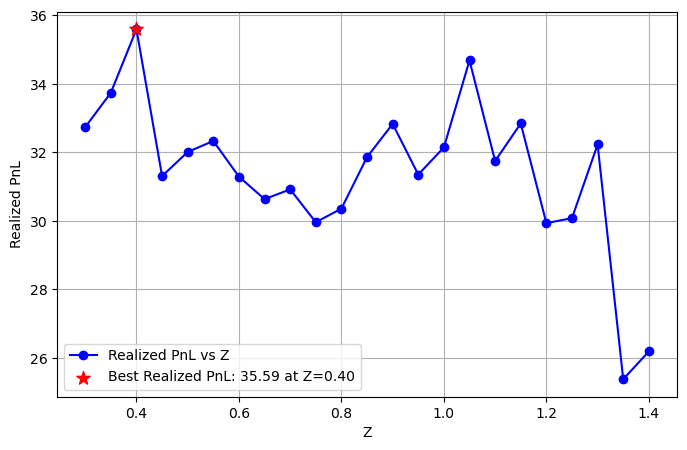

In [52]:
# Backtesting: in-sample performance evaluation on train_data
test_z_values = np.arange(0.3, 1.45, 0.05)
train_results, z_best = backtest_strategy_for_z_values(train_data, ticker1, ticker2, ou_params, hedge_ratio,
                                                       z_values=test_z_values, plotting=True)

In [53]:
train_results  # including realized and unrealized PnL (in "Total PnL (incl. Unrealized)")

,Z,Realized PnL,Total PnL (incl. Unrealized),VaR,ES
0,0.30,32.735495,32.410771,0.009132,0.008331
1,0.35,33.738990,33.414266,0.009132,0.008331
2,0.40,35.593382,35.268659,0.010917,0.010227
3,0.45,31.307174,30.982450,0.013019,0.012800
4,0.50,32.011734,32.734274,0.013298,0.013113
5,0.55,32.332451,33.054992,0.014337,0.013113
6,0.60,31.290258,32.012798,0.015584,0.014862
7,0.65,30.634987,31.357528,0.016068,0.014862
8,0.70,30.920109,31.642650,0.018647,0.017722
9,0.75,29.960389,30.682929,0.018563,0.017722


For the training data, the total PnL including unrealized gains is quite similar to the realized PnL, visible in the dataframe above, as well as in the plot below.

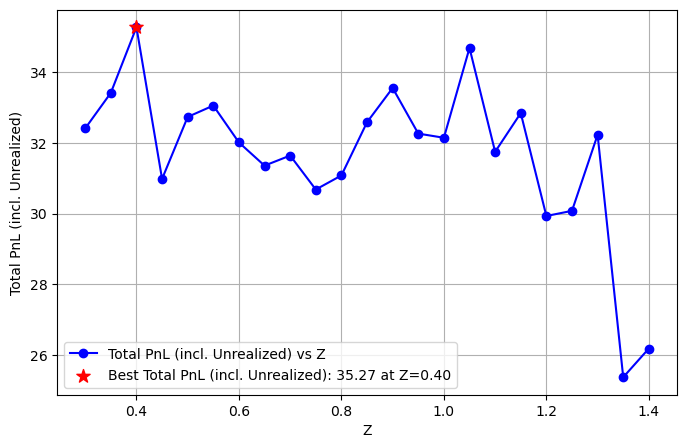

In [54]:
# Backtesting: in-sample performance evaluation on train_data
test_z_values = np.arange(0.3, 1.45, 0.05)
train_results, z_best = backtest_strategy_for_z_values(train_data, ticker1, ticker2, ou_params, hedge_ratio,
                                                       z_values=test_z_values, plotting=True, maximize_realized=False)

### Backtesting: out-of-sample performance evaluation on `test_data`

This mimicks a real-world backtesting, where one would have conceived a trading strategy after observing the assets for a while - in our case, we observed for 70% of the data from January 2020 until end of March 2023. The test period is the last 30% of the data from April 2023 until August 2024. The performance on the test data shows the following behavior:

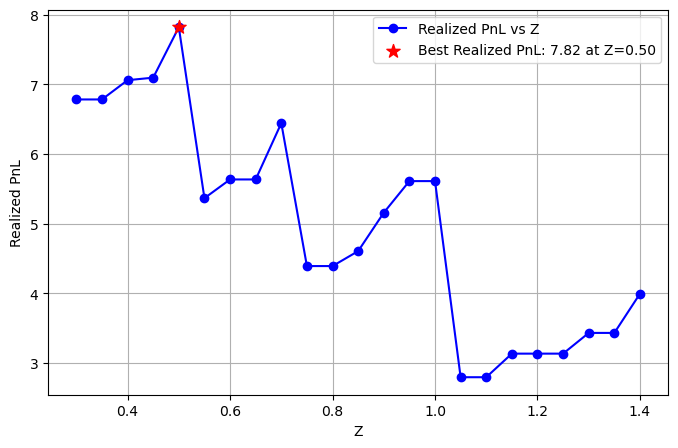

In [55]:
# Backtesting: out-of-sample performance evaluation on test_data
test_results, _ = backtest_strategy_for_z_values(test_data, ticker1, ticker2, ou_params, hedge_ratio,
                                                 z_values=test_z_values, plotting=True)

In [56]:
test_results

,Z,Realized PnL,Total PnL (incl. Unrealized),VaR,ES
0,0.30,6.784934,-0.807795,0.009103,0.008332
1,0.35,6.784934,-0.244925,0.009103,0.008332
2,0.40,7.061489,0.031630,0.011083,0.010807
3,0.45,7.097754,0.067895,0.011083,0.010807
4,0.50,7.821767,0.791908,0.011730,0.011521
5,0.55,5.367858,-1.662001,0.012951,0.012566
6,0.60,5.636705,-0.917988,0.014861,0.014688
7,0.65,5.636705,-0.917988,0.014861,0.014688
8,0.70,6.445000,-0.109693,0.017928,0.017878
9,0.75,4.393471,-2.161223,0.017999,0.017878


Here, the unrealized PnL is significantly different (often negative!) from realized PnL, indicating that the most recent market movements on positions that are currently still open have deviated far from the equilibrium mean $\mu_e$.

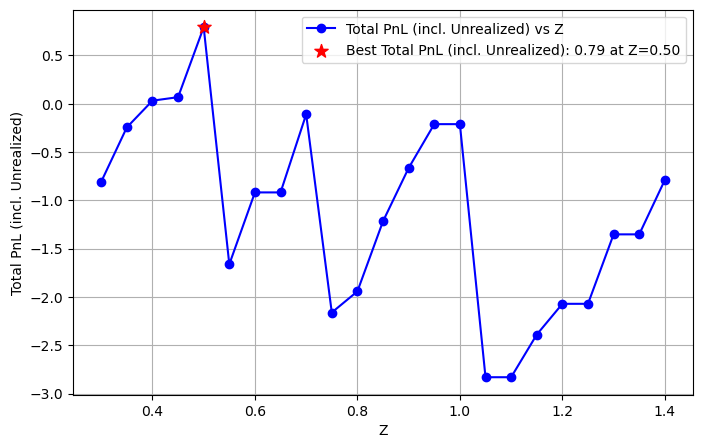

In [57]:
# Backtesting: out-of-sample performance evaluation on test_data
test_results, _ = backtest_strategy_for_z_values(test_data, ticker1, ticker2, ou_params, hedge_ratio,
                                                 z_values=test_z_values, plotting=True, maximize_realized=False)

We see that the choice of `z_best=0.4` would not have been optimal in for our test data set, but we shall still move forward with this Z-value, since I want to simulate the data split as realistically as possible. 

In [58]:
portfolio = Portfolio(test_data, ticker1, ticker2, ou_params, hedge_ratio, z=z_best)

In [59]:
# portfolio.positions
portfolio.realized_daily_pnl["2022-03-20":]

Date
2023-03-28    0.000000
2023-03-29    0.000000
2023-03-30    0.000000
2023-03-31    0.000000
2023-04-03    0.000000
                ...   
2024-08-12    7.061489
2024-08-13    7.061489
2024-08-14    7.061489
2024-08-15    7.061489
2024-08-16    7.061489
Length: 350, dtype: float64

In [60]:
test_data["residuals"]

Date
2023-03-28   -1.862945
2023-03-29   -1.802655
2023-03-30   -1.861653
2023-03-31   -2.131793
2023-04-03   -1.823033
                ...   
2024-08-12    7.339857
2024-08-13    7.338952
2024-08-14    7.048619
2024-08-15    7.483019
2024-08-16    7.982399
Name: residuals, Length: 350, dtype: float64

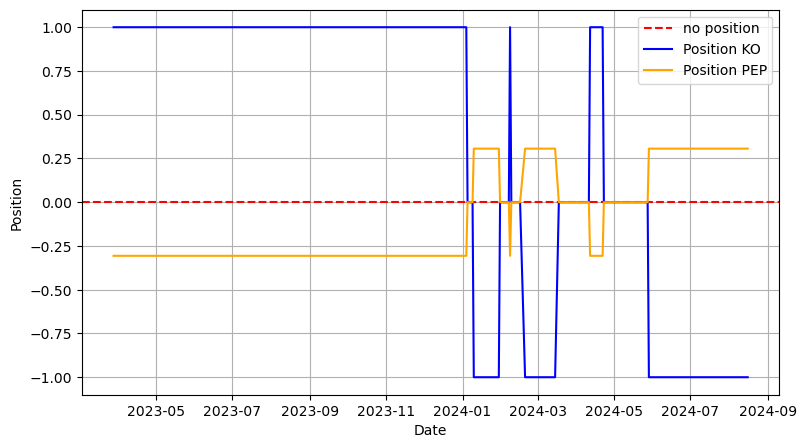

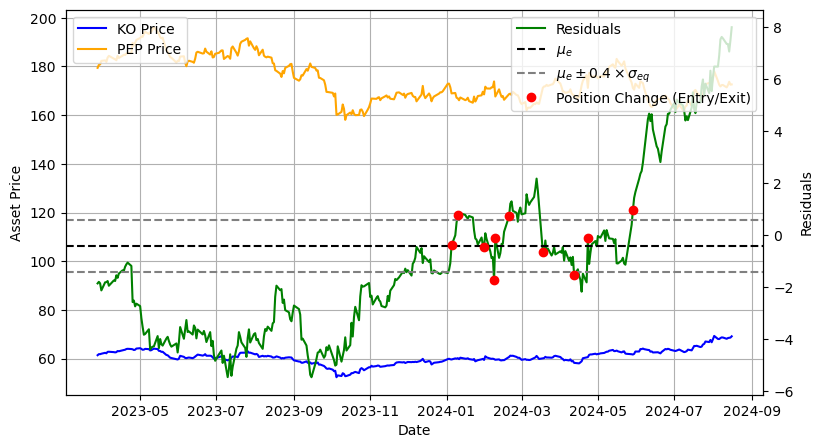

In [61]:
def plot_positions(portfolio):
    """Plot the positions of ticker1 and ticker2 over time."""
    dates = portfolio.data.index

    plt.figure(figsize=(9, 5))
    plt.axhline(0, color="r", linestyle="--", label="no position")
    plt.plot(dates, portfolio.positions[portfolio.ticker1], label=f"Position {portfolio.ticker1}", color="blue")
    plt.plot(dates, portfolio.positions[portfolio.ticker2], label=f"Position {portfolio.ticker2}", color="orange")
    plt.xlabel("Date")
    plt.ylabel("Position")
    #plt.title(f"Positions for {portfolio.ticker1} and {portfolio.ticker2} Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_asset_prices_and_residuals(portfolio):
    """Plot the asset prices and residuals with sigma_eq-bands using subplots."""
    dates = portfolio.data.index

    fig, ax1 = plt.subplots(figsize=(9, 5))

    # primary y-axis: asset prices
    ax1.plot(dates, portfolio.data[portfolio.ticker1], label=f"{portfolio.ticker1} Price", color="blue")
    ax1.plot(dates, portfolio.data[portfolio.ticker2], label=f"{portfolio.ticker2} Price", color="orange")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Asset Price")
    ax1.legend(loc="upper left")
    ax1.grid(True)

    # secondary y-axis: residuals
    residuals = pd.Series(portfolio.data['residuals'], index=dates)
    ax2 = ax1.twinx()
    ax2.plot(dates, residuals, label="Residuals", color="green")
    ax2.axhline(portfolio.mu_e, color="black", linestyle="--", label=r"$\mu_e$")
    upper_bound, lower_bound = portfolio.calculate_optimal_bounds()
    sigma_band_label = r"$\mu_e \pm " + str(round(portfolio.z, 2)) + r" \times \sigma_{eq}$"
    ax2.axhline(upper_bound, color="grey", linestyle="--", label=sigma_band_label)
    ax2.axhline(lower_bound, color="grey", linestyle="--")
    ax2.set_ylabel("Residuals")
    
    # mark entry and exit signals based on changes in positions
    positions_ticker1 = portfolio.positions[portfolio.ticker1]
    position_changes = positions_ticker1.diff().fillna(0)
    signals = position_changes != 0  # track where a position is changed
    ax2.plot(dates[signals], residuals[signals], "ro", label="Position Change (Entry/Exit)")
    ax2.legend(loc="upper right")

    #plt.title(f"Asset Prices and Residuals with Thresholds for {portfolio.ticker1} and {portfolio.ticker2}")
    plt.show()


plot_positions(portfolio)
plot_asset_prices_and_residuals(portfolio)

In [62]:
# Cumulative realized PnL
cumulative_pnl = portfolio.get_cumulative_pnl()
print(f"Cumulative Realized PnL: {cumulative_pnl}")

# Total PnL (realized + unrealized)
total_pnl = portfolio.get_total_pnl()
print(f"Total PnL (Realized + Unrealized): {total_pnl}")

Cumulative Realized PnL: 7.0614894574046945
Total PnL (Realized + Unrealized): 0.03163036490113491


We will now compare this portfolio against the index by plotting both the piece-wise constant realized PnL as well as the continuous unrealized PnL. These will be compared against a benchmark trading strategy where one would simply hold the equity index. To ensure that the scaling is comparable, we will scale the index returns to reflect the initial dollar investment in the cointegration portfolio.

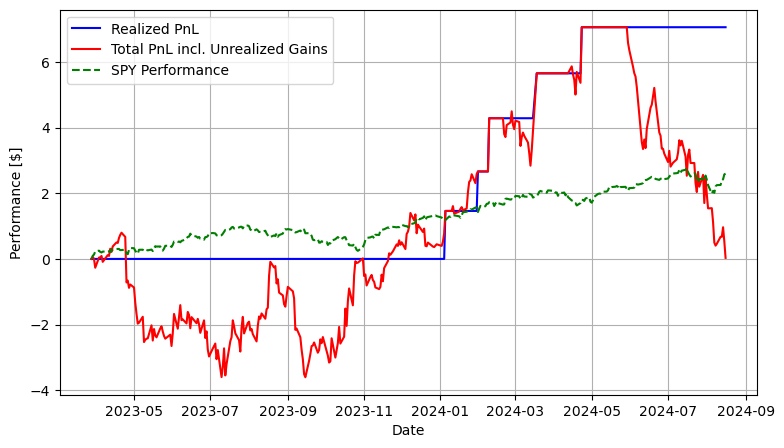

In [63]:
def get_portfolio_investment(portfolio):
    """Calculate the initial dollar investment in the portfolio."""
    ticker1 = portfolio.ticker1
    ticker2 = portfolio.ticker2

    # boolean series for non-zero positions in ticker1 and ticker2
    condition_ticker1 = portfolio.positions[ticker1] != 0
    condition_ticker2 = portfolio.positions[ticker2] != 0
    combined_condition = np.logical_or(condition_ticker1, condition_ticker2)

    # find index of the first non-zero position
    first_trade_date_idx = portfolio.positions[combined_condition].index[0]

    # entry prices at first trade date
    entry_price_ticker1 = portfolio.data.loc[first_trade_date_idx, ticker1]
    entry_price_ticker2 = portfolio.data.loc[first_trade_date_idx, ticker2]
    
    # positions of first trade date
    position_ticker1 = portfolio.positions.loc[first_trade_date_idx, ticker1]
    position_ticker2 = portfolio.positions.loc[first_trade_date_idx, ticker2]
    return entry_price_ticker1 * position_ticker1 + entry_price_ticker2 * position_ticker2


def plot_pnl_against_index(portfolio, index_ticker):
    """Plot the portfolio PnL compared to index performance."""
    realized_pnl = portfolio.realized_daily_pnl
    total_pnl = portfolio.unrealized_daily_pnl + portfolio.realized_daily_pnl
    dates = portfolio.data.index

    # calculate cumulative index return and scale to portfolio investment
    index_prices = portfolio.data[index_ticker]
    initial_index_price = index_prices.iloc[0]
    normalized_index_return = (index_prices - initial_index_price) / initial_index_price
    index_return_scaled = normalized_index_return * get_portfolio_investment(portfolio)

    plt.figure(figsize=(9, 5))
    plt.plot(dates, realized_pnl, label="Realized PnL", color="blue")
    plt.plot(dates, total_pnl, label="Total PnL incl. Unrealized Gains", color="red")
    plt.plot(dates, index_return_scaled, label=f"{index_ticker} Performance", color="green", linestyle="--")
    #plt.title(f"PnL Evolution over Test Data Period - compared against {index_ticker} index")
    plt.xlabel("Date")
    plt.ylabel("Performance [$]")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_pnl_against_index(portfolio, index_ticker="SPY")

### A look at the optimal portfolio during training phase

This should supposably yield the most a profitable strategy, since all parameter optization was performed on this period

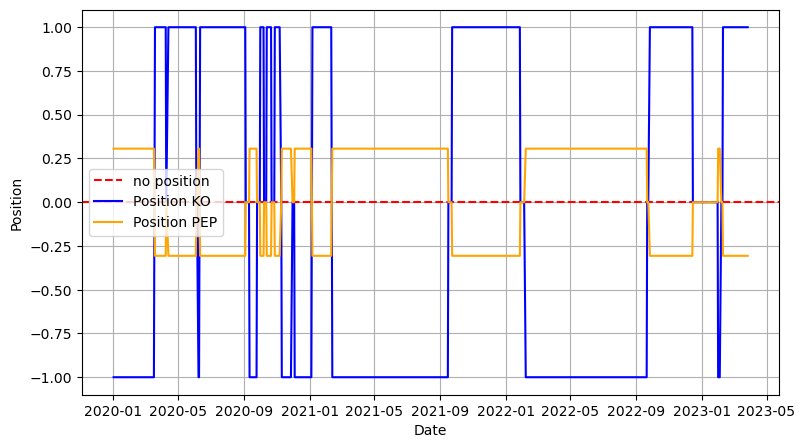

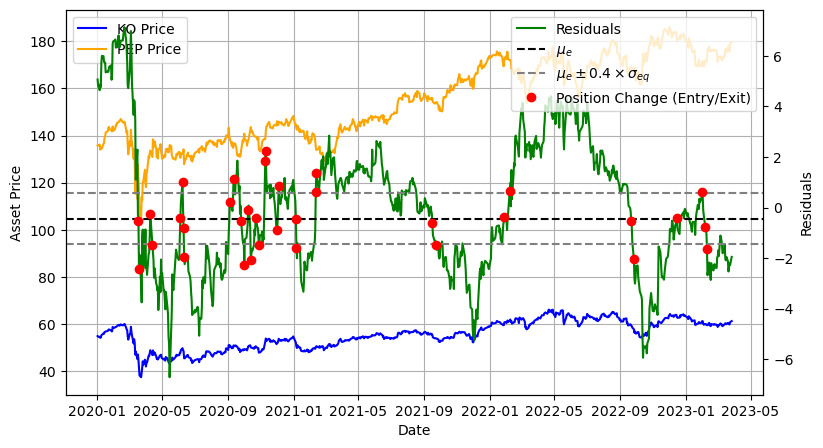

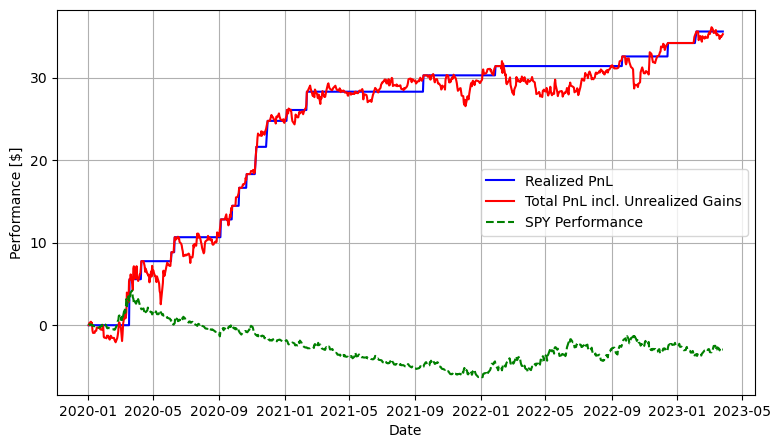

In [64]:
optimal_training_portfolio = Portfolio(train_data, ticker1, ticker2, ou_params, hedge_ratio, z=z_best)
plot_positions(optimal_training_portfolio)
plot_asset_prices_and_residuals(optimal_training_portfolio)
plot_pnl_against_index(optimal_training_portfolio, index_ticker="SPY")

The performance during the training period significantly outperformed the benchmark, and trading activity was higher. In an overall sideways tending market (indicated by the relatively flat performance of the S&P 500 index during this period), our strategy successfully capitalized on short-term price fluctuations between KO and PEP, leading to substantial realized and unrealized profits. The increased trading frequency during this period suggests that the strategy was well-tuned to arbitrage on inefficiencies and temporary deviations in the price relationship between KO and PEP.

### Using a higher Z-value for test purposes...

In [65]:
portfolio_high_z = Portfolio(test_data, ticker1, ticker2, ou_params, hedge_ratio, z=1)

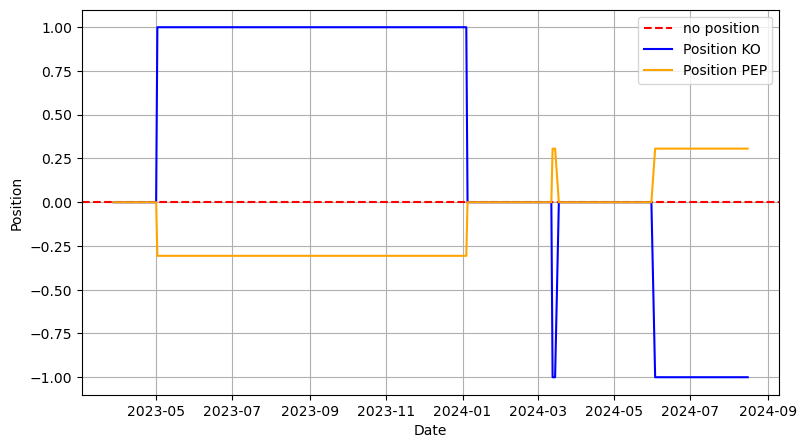

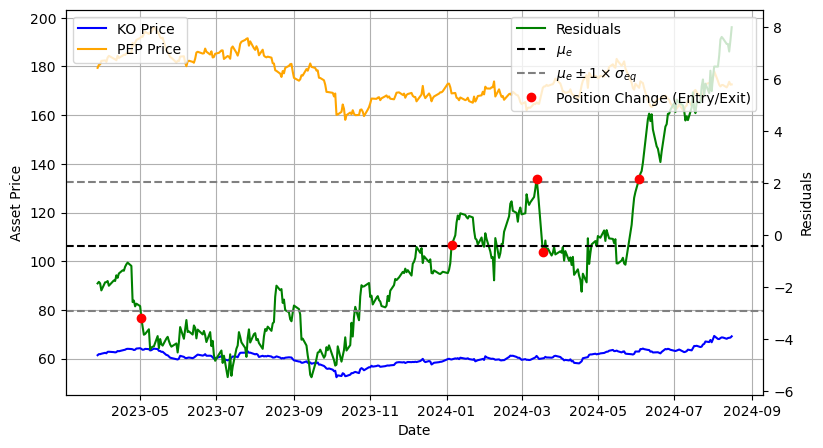

In [66]:
plot_positions(portfolio_high_z)
plot_asset_prices_and_residuals(portfolio_high_z)

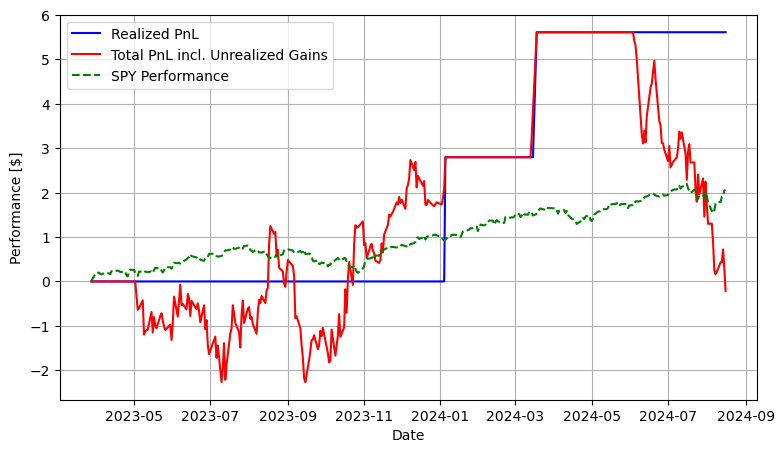

In [67]:
plot_pnl_against_index(portfolio_high_z, index_ticker="SPY")

# Function wrapping so analysis can be easier applied to other asset pairs

In [68]:
def perform_engle_granger_step1(ticker1, ticker2, index_ticker, train_data, test_data,
                                plotting, significance_level, maxlag):
    """Step1 of the Engle-Granger procedure."""

    # OLS regression to obtain regression coefficients beta & residuals
    y = train_data[ticker1].values
    X = train_data[ticker2].values.reshape(-1, 1)
    beta, residuals = least_squares_regression(y, X)
    train_data['residuals'] = residuals
    test_data['residuals'] = calculate_test_residuals(test_data, beta, ticker1, ticker2)

    if plotting:  # plot normalized asset prices and residuals
        plot_assets_and_residuals(train_data, test_data, ticker1, ticker2, index_ticker)

    # perform ADF test
    adf_test_result = perform_adf_test(train_data['residuals'], significance_level, maxlag)
    return train_data, test_data, beta, adf_test_result


def analyze_cointegration(ticker1, ticker2, index_ticker="SPY",
                          plotting=False, start_date="2014-01-01",
                          significance_level=0.05, maxlag=None):
    """Analyze cointegration between two assets ticker1 & ticker2 after start_date <YYYY-MM-DD>."""
    print(f"-" * 100)
    print(f"Analyzing cointegration between {ticker1} and {ticker2}...")

    df1 = download_data(ticker1, start_date)
    df2 = download_data(ticker2, start_date)
    data = prepare_time_series(df1, df2, ticker1, ticker2, index_ticker)

    # test / train split:
    train_data, test_data = split_data(data, split_ratio=0.7)

    # Engle-Granger procedure - Step 1
    train_data, test_data, beta, adf_test_result = perform_engle_granger_step1(ticker1, ticker2, index_ticker,
                                                                               train_data, test_data, plotting,
                                                                               significance_level, maxlag)
    # Engle-Granger procedure - Step 2: ECM
    lag_size = adf_test_result[2]
    ecm_results = fit_ecm(train_data, ticker1, ticker2, lag_size)
    print(f"Equilibrium mean-reversion coefficient: {ecm_results['coefficients'][-1]:2f}")

    # Engle-Granger procedure - Step 3 (inofficial): fit OU process to mean-reverting residuals
    theta, mu_e, sigma_ou = estimate_ou_params(train_data['residuals'])
    print(f"Estimated OU parameters: theta={theta:.4f}, mu_e={mu_e:.4f}, sigma_ou={sigma_ou:.4f}")
    print(f"Half-life of OU process: {np.log(2) / (theta):.2f} days")
    ou_params = {'theta': theta, 'mu_e': mu_e, 'sigma_ou': sigma_ou}
    return train_data, test_data, beta, adf_test_result, ecm_results, ou_params


def analyze_trading_strategy(train_data, test_data, ticker1, ticker2, ou_params, hedge_ratio, index_ticker="SPY",
                             test_z_values=np.arange(0.3, 1.5, 0.05)):
    # Backtesting: in-sample performance evaluation on train_data to find best z-value
    train_results, z_best = backtest_strategy_for_z_values(train_data, ticker1, ticker2, ou_params, hedge_ratio, test_z_values)

    # Implement + analyze strategy with optimized z=z_best on test_data
    test_portfolio = Portfolio(test_data, ticker1, ticker2, ou_params, hedge_ratio, z=z_best)
    plot_positions(test_portfolio)
    plot_asset_prices_and_residuals(test_portfolio)
    plot_pnl_against_index(test_portfolio, index_ticker)

# Reversing the roles of KO and PEP:

In [69]:
ticker1 = "PEP"
ticker2 = "KO"

In [70]:
train_data, test_data, beta, adf_test_result, ecm_results, ou_params = analyze_cointegration(ticker1, ticker2,
                                                                                             start_date="2020-01-01",
                                                                                             maxlag=1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

----------------------------------------------------------------------------------------------------
Analyzing cointegration between PEP and KO...
ADF Statistic: -2.6576
p-value: 0.0817
Number of lags: 1
The residuals are not stationary (fail to reject null hypothesis) at the 5.0% significance level.
Equilibrium mean-reversion coefficient: -0.014896


Estimated OU parameters: theta=0.0186, mu_e=1.7735, sigma_ou=-1.3922
Half-life of OU process: 37.22 days


The residuals are not stationary with lag size $1$... But our strategy is based on the assumption that the assets are cointegrated with mean-reverting spread! But what if we turn on lag optimization?

In [71]:
train_data, test_data, beta, adf_test_result, ecm_results, ou_params = analyze_cointegration(ticker1, ticker2,
                                                                                             start_date="2020-01-01")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

----------------------------------------------------------------------------------------------------
Analyzing cointegration between PEP and KO...
ADF Statistic: -3.0287
p-value: 0.0323
Number of lags: 21
The residuals are stationary (reject null hypothesis) at the 5.0% significance level.
Equilibrium mean-reversion coefficient: -0.012674


Estimated OU parameters: theta=0.0186, mu_e=1.7735, sigma_ou=-1.3922
Half-life of OU process: 37.22 days


We are in luck - the null hypothesis is failed to be rejected and therefore, PEP and KO are cointegrated at 5\% significance level! We will proceed with these parameters, using a AIC-optimized lag size of 21.

In [72]:
beta

array([9.15949691, 2.61111547])

We find the hedge ratio of the reversed cointegration study of PEP and KO (instead of previoulsy considered KO and PEP) to be $\beta_1 \approx 2.6111$.

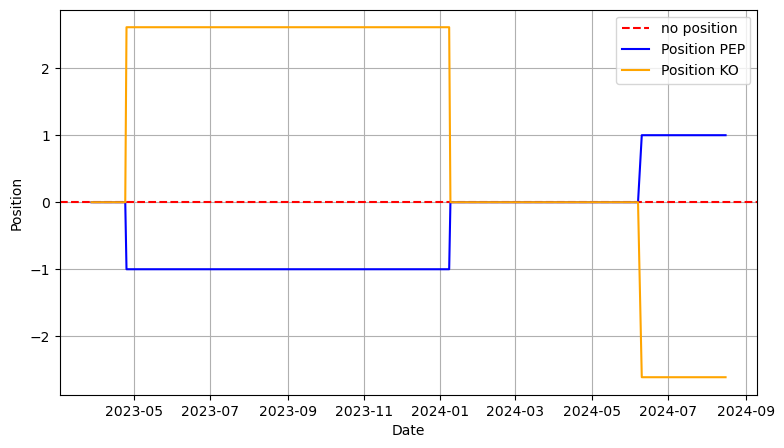

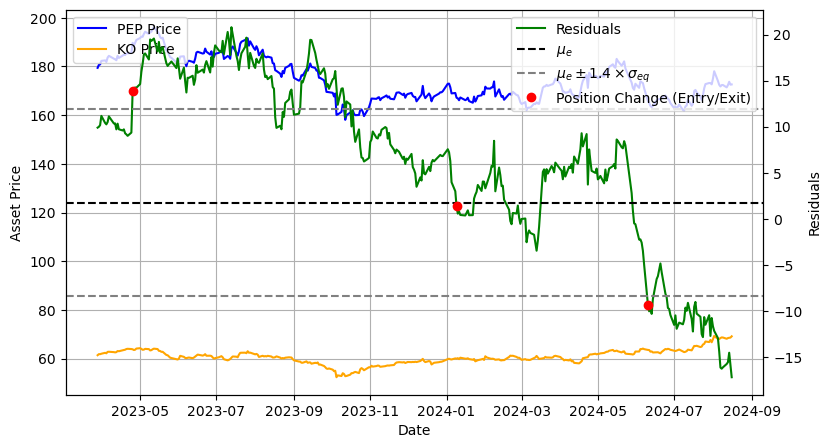

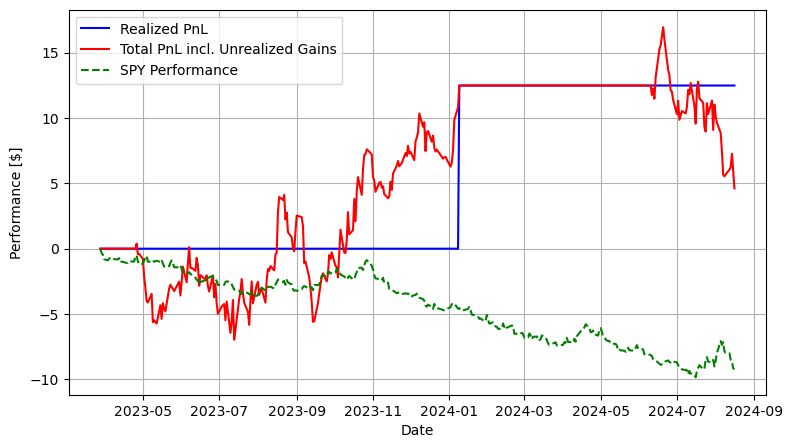

In [73]:
analyze_trading_strategy(train_data, test_data, ticker1, ticker2, ou_params, beta[1])

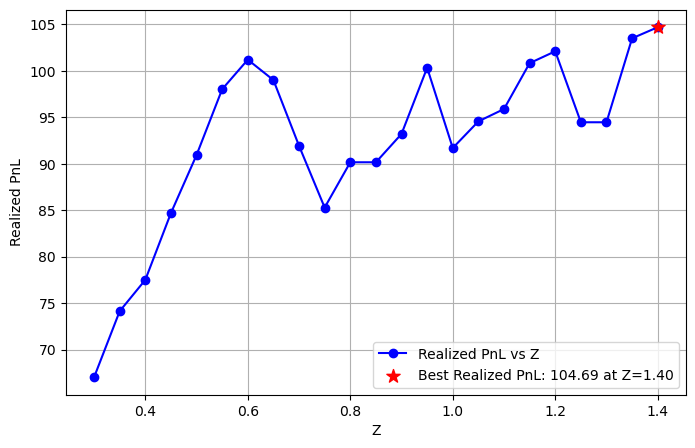

In [74]:
# Backtesting: in-sample performance evaluation on train_data
test_z_values = np.arange(0.3, 1.45, 0.05)
train_results_reversed, z_best_reversed = backtest_strategy_for_z_values(train_data, ticker1, ticker2, ou_params,
                                                                         beta[1], z_values=test_z_values,
                                                                         plotting=True, maximize_realized=True)

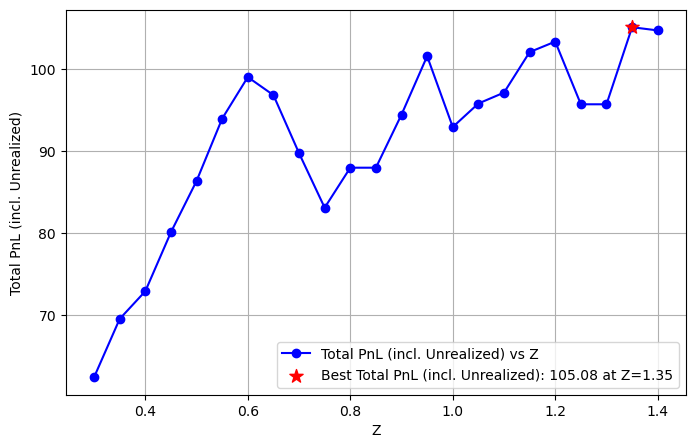

In [75]:
# Backtesting: in-sample performance evaluation on train_data
test_z_values = np.arange(0.3, 1.45, 0.05)
train_results_reversed, z_best_reversed = backtest_strategy_for_z_values(train_data, ticker1, ticker2, ou_params,
                                                                         beta[1], z_values=test_z_values,
                                                                         plotting=True, maximize_realized=False)

In [76]:
train_results_reversed

,Z,Realized PnL,Total PnL (incl. Unrealized),VaR,ES
0,0.30,67.032831,62.443950,0.008165,0.007521
1,0.35,74.140088,69.551206,0.008938,0.008441
2,0.40,77.510633,72.921752,0.011372,0.009151
3,0.45,84.699532,80.110651,0.012568,0.012567
4,0.50,90.942312,86.353431,0.013333,0.012569
5,0.55,98.023420,93.949529,0.013703,0.012569
6,0.60,101.200083,99.007305,0.015994,0.014313
7,0.65,99.002862,96.810084,0.019275,0.018757
8,0.70,91.929536,89.736758,0.019885,0.019621
9,0.75,85.288987,83.096208,0.019858,0.019621


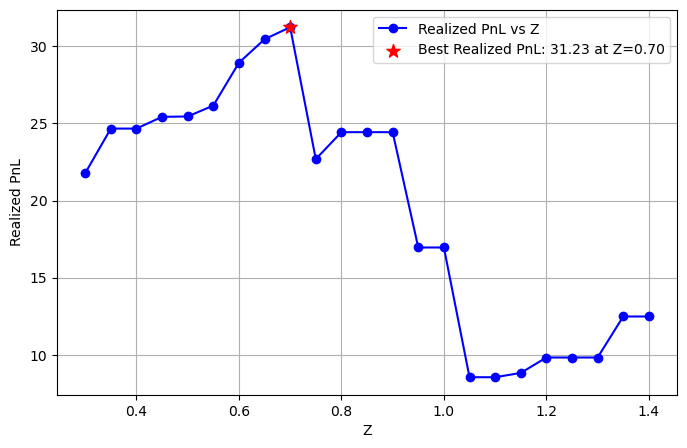

In [77]:
# Backtesting: out-of-sample performance evaluation on test_data
test_z_values = np.arange(0.3, 1.45, 0.05)
test_results_reversed, _ = backtest_strategy_for_z_values(test_data, ticker1, ticker2, ou_params,
                                                          beta[1], z_values=test_z_values,
                                                          plotting=True, maximize_realized=True)

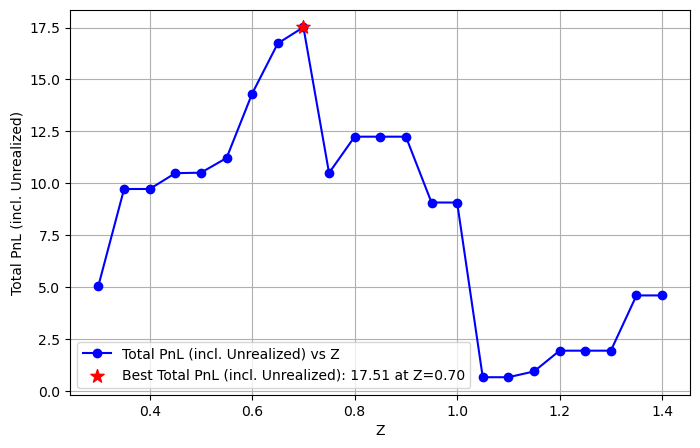

In [78]:
# Backtesting: out-of-sample performance evaluation on test_data
test_z_values = np.arange(0.3, 1.45, 0.05)
test_results_reversed, _ = backtest_strategy_for_z_values(test_data, ticker1, ticker2, ou_params,
                                                          beta[1], z_values=test_z_values,
                                                          plotting=True, maximize_realized=False)

In [79]:
test_results_reversed

,Z,Realized PnL,Total PnL (incl. Unrealized),VaR,ES
0,0.30,21.772792,5.086652,0.010021,0.009382
1,0.35,24.661127,9.731654,0.012404,0.012186
2,0.40,24.661127,9.731654,0.012404,0.012186
3,0.45,25.422244,10.492772,0.013768,0.013640
4,0.50,25.445566,10.516094,0.013784,0.013657
5,0.55,26.151674,11.222202,0.014662,0.014498
6,0.60,28.927788,14.323305,0.016644,0.015587
7,0.65,30.448918,16.735008,0.019001,0.018359
8,0.70,31.228352,17.514442,0.020961,0.020665
9,0.75,22.683362,10.502784,0.020862,0.020665


Best portfolio is found $Z=Z^*=1.35$. The resulting bounds are:

In [323]:
portfolio_reversed = Portfolio(test_data, ticker1, ticker2, ou_params,  beta[1], z=z_best_reversed)
portfolio_reversed.calculate_optimal_bounds()

(11.511799648165528, -7.964755885700034)

In [324]:
print(f"Realized PnL: {portfolio_reversed.get_cumulative_pnl()}")
print(f"Total PnL incl. unrealized PnL: {portfolio_reversed.get_total_pnl()}")

Realized PnL: 12.487217956389395
Total PnL incl. unrealized PnL: 4.611083282088222


# Considering another asset pair: Apple & Microsoft

In [ ]:
ticker1 = "AAPL"
ticker2 = "MSFT"
train_data, test_data, beta, adf_test_result, ecm_results, ou_params = analyze_cointegration(ticker1, ticker2,
                                                                                             start_date="2021-01-01",
                                                                                             plotting=True)

In [ ]:
analyze_trading_strategy(train_data, test_data, ticker1, ticker2, ou_params, beta[1])

# Considering another asset pair: Nestlé & Roche (two large Swiss stocks)

In [ ]:
ticker1 = "NESN.SW"
ticker2 = "ROG.SW"
train_data, test_data, beta, adf_test_result, ecm_results, ou_params = analyze_cointegration(ticker1, ticker2,
                                                                                             index_ticker="^SSMI",
                                                                                             plotting=True,
                                                                                             start_date="2017-01-01")

In [ ]:
analyze_trading_strategy(train_data, test_data, ticker1, ticker2, ou_params, beta[1],  index_ticker="^SSMI")

# Considering another asset pair: Lonza & Givaudan (another pair of large Swiss stocks)

In [ ]:
ticker1 = "LONN.SW"
ticker2 = "GIVN.SW"
train_data, test_data, beta, adf_test_result, ecm_results, ou_params = analyze_cointegration(ticker1, ticker2,
                                                                                             index_ticker="^SSMI",
                                                                                             plotting=True,
                                                                                             start_date="2017-01-01")

In [ ]:
analyze_trading_strategy(train_data, test_data, ticker1, ticker2, ou_params, beta[1],  index_ticker="^SSMI")